In [1]:
import glob
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import random

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer



from sklearn.metrics import confusion_matrix
import itertools
from sklearn.externals import joblib

In [2]:
def read_in_dataframes():
    f_list = glob.glob('*_data_df.p')
    df_list = []
    for fname in f_list:
        if 'jupyter' not in fname:
            #if 'guard' in fname:
            df_list.append(pickle.load(open( fname, 'rb' )))
            #print(len(list(df_list[-1])))
    #print(df_list[5])
    print(list(df_list[0]))
    return df_list

def concat_dfs(df_list):
    return pd.concat(df_list)


In [3]:
def get_pub_names(df_list):
    pub_names = [i.loc[0,'label'] for i in df_list]
    return pub_names

def encode_pub_names(full_feature_df, pub_names):
    le = preprocessing.LabelEncoder()
    le.fit(pub_names)
    print('pub', list(le.classes_))
    label_array = full_feature_df['label'].values
    Y = le.transform(label_array)
    return Y, list(le.classes_)


def get_feature_array(full_feature_df, feat_list):
    return full_feature_df[feat_list].values


In [4]:
def modify_full_dataframe(full_feature_df):
    #full_feature_df = full_feature_df.loc[full_feature_df['sent_count'] > 10]

    #full_feature_df['sent_len_mean_over_std'] = full_feature_df['sent_len']/full_feature_df['sent_len_std']
    #full_feature_df = full_feature_df.loc[(full_feature_df['sent_len_std'] > 0) & (full_feature_df['sent_len'] > 0)]

    #full_feature_df['flesch_dff'] = full_feature_df['flesch_five'] - full_feature_df['flesch']
    #full_feature_df['fq1'] = full_feature_df['flesch_sec'].str[0]
    #full_feature_df['fq2'] = full_feature_df['flesch_sec'].str[1]
    #full_feature_df['fq3'] = full_feature_df['flesch_sec'].str[2]
    #full_feature_df['fq4'] = full_feature_df['flesch_sec'].str[3]
    #full_feature_df['flesch_slope'] = full_feature_df['flesch_sec'].apply(lambda row: sum([row[ci+1] - row[ci] for ci in range(3)])/4)
    #print(full_feature_df['flesch_slope'])
    min_word_count = 100
    full_feature_df = full_feature_df.loc[(full_feature_df['word_count'] > min_word_count)]
    return full_feature_df

In [5]:
def save_mean_vals(df_list, pub_names):
    mean_values = []
    for ci,label_id in enumerate(pub_names):
        mean_values.append(df_list[ci][feat_list].mean().tolist())
    pickle.dump(mean_values, open('mean_features.p', 'wb'))


In [6]:
def plot_feature_histograms(df_list, feat_list, pub_names):
    plt.xlabel('Commas per sentence')
    legend = []
    for ci,label_id in enumerate(pub_names):
        if label_id in ['nyt','breit','wapo']:
            legend.append(label_id)
            df_list[ci].loc[(df_list[ci]['word_count'] < 6000) & (df_list[ci]['sent_len'] < 70)]['cps'].hist(
                bins = [i/100 for i in range(0,300,5)], alpha = 0.5, normed = True)
    plt.legend(legend)

In [7]:
def feature_correlations(full_feature_df):
    corr = full_feature_df[feat_list].corr()
    
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    plt.figure(figsize=(10,10))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr,cmap=cmap, center=0,
                square=True, linewidths=.3, cbar_kws={"shrink": .8})

In [42]:
def train_model(model, X_train, y_train, title):

    #for i in range(100,4500, 400):
    #    rand_start = random.randint(0,4500 - i)
    #    rf_clf = rf_clf.fit(X_train[rand_start:rand_start + i], y_train[rand_start:rand_start + i])

    #    print(rf_clf.score(X_test, y_test))
    model = model.fit(X_train, y_train)
    return model
    
    
    
def score_model(y_test, y_pred, pub_names, title):
    
    #print(model.score(X_test, y_test))
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=pub_names,
                      title='Confusion matrix: ' + title, normalize = True)

    #plot_auc_roc(model)
    #return y_pred
    
    
def score_model_top_two(y_test, y_pred_prob, pub_names, title):
    
    #print(model.score(X_test, y_test))
    y_pred = []
    for true, row in zip(y_test, y_pred_prob):
        if true in row.argsort()[-2:][::-1]:
            y_pred.append(true)
        else:
            y_pred.append(row.argmax())
                
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=pub_names,
                      title='Confusion matrix: ' + title, normalize = True)

    #plot_auc_roc(model)
    #return y_pred
    
    
    
def plot_auc_roc(model):
    # Compute ROC curve and ROC area for each class
    one_v_rest = OneVsRestClassifier(model).fit(X_train, y_train)
    print(one_v_rest.score(X_test, y_test))
    y_pred = one_v_rest.predict(X_test)
    y_score = one_v_rest.fit(X_train, y_train).decision_function(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #print(len(class_names))
    #print(len(y_test))
    #print(len(y_score))
    for i in range(len(pub_names)):
        fpr[i], tpr[i], _ = roc_curve( (y_test == i).astype(int), y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    #fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    #roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    plt.figure()
    lw = 2
    for i in range(9):
        plt.plot(fpr[i], tpr[i], 
                 lw=lw, label='{} (area = {})'.format(str(class_names[i]), str(roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
#New York Times', 'Breitbart', 'Washington Post', 'Guardian']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha = 'right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix

def feature_importances(model, feat_list):
    n_features = len(feat_list)
    importances = model.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in xg_clf.estimators_],
    #             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(n_features):#.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

        # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n_features), importances[indices],
           color="r", align='center')#, yerr=std[indices], align="center")
    #plt.bar(range(40), importances[indices[:40]],
    #       color="r", align='center')#, yerr=std[indices], align="center")

    print(indices)
    plt.xticks(range(n_features), [feat_list[i] for i in indices], rotation = 45, ha = 'right')
    plt.xlim([-1, n_features])
    #plt.xticks(range(40), [feature_names[i] for i in indices[:40]], rotation = 45, ha = 'right')
    #plt.xlim([-1, 40])

    plt.show()



In [9]:
def tsne(X, Y):
    #X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2).fit_transform(X)
    print(X_embedded.shape)

    colorlist = 'rgbcmykrg'
    color = [colorlist[i] for i in Y]
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color, cmap=plt.cm.Spectral, s = 0.5)

In [10]:
#read in data and concatenate into large dataframe
df_list = read_in_dataframes()
full_feature_df = concat_dfs(df_list)

#trim the dataframe (e.g. to cut out short articles) or add new feature columns
full_feature_df = modify_full_dataframe(full_feature_df)

#set feature list
#feat_list = ['word_count', 'sent_len', 'word_len', 'sent_len_std', 'unique_word_frac',                                                                     
#                'cps', 'qps', 'exps', 'foreign', 'flesch',                                                                                                     
#                'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps',                                                                                                
#                'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps',                                                                 
#                'said_ps', 'and_ps', 'but_ps', 'told_ps', 'i_ps', 'pronoun_ps', 'determiner_ps', 
#                'preposition_ps', 'word_rarity']
             
feat_list = ['sent_len', 'word_len', 'sent_len_std', 'unique_word_frac',                                                                     
                'cps', 'flesch',                                                                                               
                'said_ps', 'qps', 'and_ps', 'but_ps', 'told_ps', 'i_ps', 'word_rarity' , 'pos_string'  ]

#encode label ids, and get target publication list
pub_names = get_pub_names(df_list)
print(pub_names)
pub_names_original_order = pub_names
Y, pub_names = encode_pub_names(full_feature_df, pub_names)
X = get_feature_array(full_feature_df, feat_list)
n_samples = len(X)


article_counts = full_feature_df.groupby('label')['label'].count().tolist()

cumulative_bounds = [0]
for ci, i in enumerate(article_counts):
    cumulative_bounds.append(i+cumulative_bounds[ci])
print(cumulative_bounds)


#X_scaled = preprocessing.scale(X)

#test train split
indices = np.arange(n_samples)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.2)

['label', 'word_count', 'sent_len', 'word_len', 'sent_len_std', 'unique_word_frac', 'cps', 'qps', 'exps', 'adverbs', 'verbs', 'adjectives', 'foreign', 'flesch', 'said_ps', 'and_ps', 'but_ps', 'flesch_five', 'flesch_sec', 'total_adv', 'total_verb', 'total_adj', 'sent_count', 'adv_ps', 'verb_ps', 'adj_ps', 'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps', 'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps', 'told_ps', 'i_ps', 'ngram_DT NN', 'ngram_NN NN', 'ngram_NN IN', 'ngram_IN DT', 'ngram_NN PP', 'ngram_JJ NN', 'ngram_IN NN', 'ngram_NN VB', 'ngram_PRP VB', 'ngram_VB IN', 'ngram_DT JJ', 'ngram_PP NN', 'ngram_PP PP', 'ngram_VB DT', 'ngram_CD NN', 'ngram_PP JJ', 'ngram_PP DT', 'ngram_PP VB', 'ngram_VB VB', 'ngram_PRP$ NN', 'ngram_TO VB', 'ngram_CD PP', 'ngram_NN CC', 'ngram_VB NN', 'ngram_PP PRP', 'ngram_VB JJ', 'ngram_MD VB', 'ngram_IN JJ', 'ngram_VB PP', 'ngram_PP IN', 'ngram_$ CD', 'ngram_PP CC', 'ngram_RB VB', 'ngram_VB RB', 'ngram_PP CD', 'ngram_JJ JJ', 'ngra

/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


['nyt', 'atl', 'fox', 'natrev', 'breit', 'wapo', 'buzz', 'vox', 'guard']
pub ['atl', 'breit', 'buzz', 'fox', 'guard', 'natrev', 'nyt', 'vox', 'wapo']
[0, 4921, 9676, 14454, 18733, 23602, 28510, 33483, 38424, 43302]


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


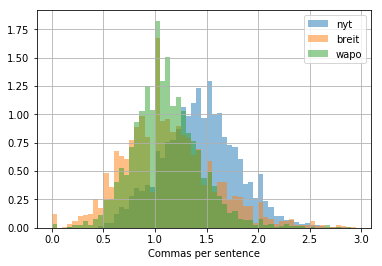

In [11]:
plot_feature_histograms(df_list, feat_list, pub_names_original_order)

In [12]:
model = RandomForestClassifier(n_estimators=50)
#model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,max_depth=5)

X_stats_train = X_train[:, :-1]
X_stats_test = X_test[:,:-1]


stats_pipeline = Pipeline([
    ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=8)),
])


stats_pipeline.fit(X_stats_train, y_train)

Pipeline(memory=None,
     steps=[('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [67]:
#train_model(model, X_stats_train, y_train)

y_stats_pred = stats_pipeline.predict(X_stats_test)

In [13]:
y_stats_pred_prob = stats_pipeline.predict_proba(X_stats_test)
print(y_stats_pred_prob)

[[0.00368844 0.02819508 0.29955457 ... 0.01787851 0.00374569 0.01896787]
 [0.34435421 0.02629614 0.02376942 ... 0.2402581  0.03422193 0.02629332]
 [0.17332185 0.06411701 0.11825006 ... 0.06980771 0.09324991 0.18403363]
 ...
 [0.04021657 0.02307006 0.00494001 ... 0.04779129 0.01044457 0.09470773]
 [0.34420303 0.02447762 0.2209641  ... 0.0516034  0.01488118 0.22949054]
 [0.01118064 0.51555796 0.03855354 ... 0.03391583 0.00919506 0.03157619]]


Normalized confusion matrix
[[0.64 0.04 0.03 0.03 0.05 0.06 0.04 0.04 0.06]
 [0.04 0.65 0.04 0.07 0.05 0.06 0.02 0.03 0.04]
 [0.04 0.07 0.64 0.07 0.06 0.02 0.03 0.03 0.05]
 [0.03 0.07 0.07 0.62 0.06 0.03 0.03 0.02 0.08]
 [0.06 0.05 0.06 0.06 0.56 0.06 0.04 0.05 0.06]
 [0.05 0.04 0.01 0.01 0.03 0.75 0.01 0.07 0.03]
 [0.05 0.03 0.04 0.03 0.05 0.02 0.72 0.03 0.04]
 [0.05 0.05 0.02 0.02 0.05 0.07 0.01 0.67 0.05]
 [0.06 0.06 0.04 0.05 0.05 0.09 0.06 0.06 0.53]]


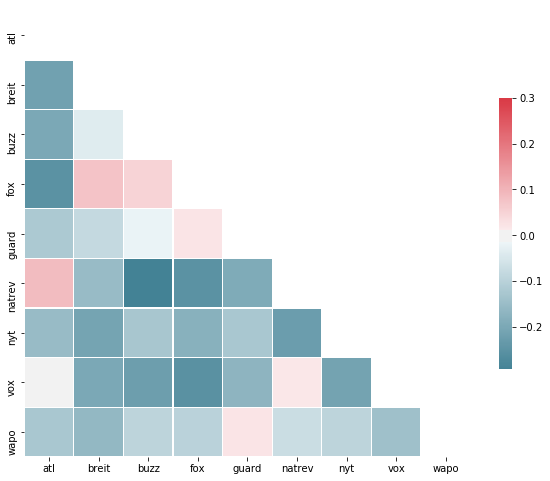

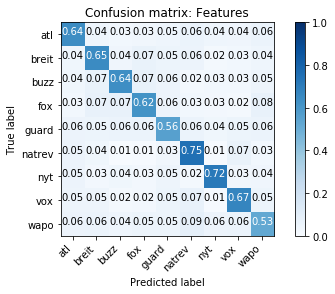

In [44]:
#top_one = y_stats_pred_prob[np.where( np.argmax(y_stats_pred_prob) == 2 )]#, interpolation = None)
#top_one = [i for i in y_stats_pred_prob if np.argmax(i) == 0]
#print(top_one)
#plt.imshow(top_one[:30], interpolation = None)

corr = pd.DataFrame({pub_names[i]: (y_stats_pred_prob[:,i]) for i in range(len(pub_names))}).corr()
    
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(10,10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, center=0, mask = mask, vmax=.3,
            square=True, linewidths=.3, cbar_kws={"shrink": .5})


#for i in range(9):
#    for j in range(i+1,9):
#        plt.title(str(i) + ' ' + str(j))
#        plt.scatter((y_stats_pred_prob[:,i]), (y_stats_pred_prob[:,j]))
#        plt.show()
score_model_top_two(y_test, y_stats_pred_prob, pub_names, 'Features')


             precision    recall  f1-score   support

          0       0.40      0.39      0.39       954
          1       0.40      0.43      0.42       929
          2       0.45      0.43      0.44       944
          3       0.39      0.41      0.40       832
          4       0.34      0.31      0.32       982
          5       0.44      0.54      0.49       997
          6       0.63      0.62      0.63       987
          7       0.54      0.52      0.53      1035
          8       0.34      0.29      0.31      1001

avg / total       0.44      0.44      0.44      8661

Normalized confusion matrix
[[0.39 0.05 0.06 0.04 0.08 0.16 0.06 0.09 0.06]
 [0.03 0.43 0.1  0.13 0.07 0.1  0.02 0.04 0.07]
 [0.04 0.09 0.43 0.12 0.11 0.04 0.04 0.04 0.08]
 [0.05 0.14 0.12 0.41 0.09 0.04 0.05 0.02 0.09]
 [0.08 0.1  0.09 0.1  0.31 0.08 0.08 0.07 0.09]
 [0.12 0.06 0.01 0.02 0.05 0.54 0.01 0.13 0.06]
 [0.08 0.03 0.04 0.03 0.07 0.02 0.62 0.03 0.08]
 [0.1  0.07 0.02 0.02 0.06 0.12 0.01 0.52 0.08]
 [

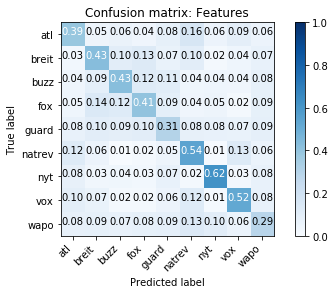

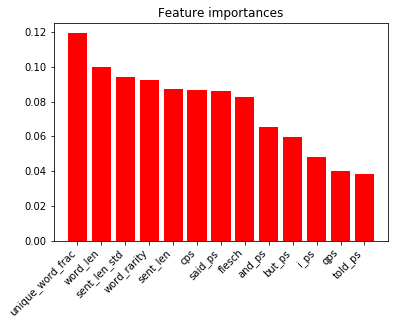

In [78]:
print(classification_report(y_test, y_stats_pred))

score_model(y_test, y_stats_pred, pub_names, 'Features')

feature_importances(stats_pipeline.steps[0][1], feat_list[:-1])

#tsne(X,Y)

In [31]:
#save model
joblib.dump(stats_pipeline, 'stats_gbt.pkl') 

['stats_gbt.pkl']

In [16]:
#from sklearn.naive_bayes import MultinomialNB
#clf = MultinomialNB().fit(X_train_tfidf, y_pos_train)
#X_pos = full_feature['pos_string'].values

#X_pos_train, X_pos_test, y_pos_train, y_pos_test, idx_pos_train, idx_pos_test = train_test_split(
#    full_feature_df['pos_string'].values, Y, indices, test_size=0.2)


#print(len(full_feature_df['pos_string']))

X_pos_train = X_train[:, -1]
X_pos_test = X_test[:,-1]
print(X_pos_train[0])

NN PP VB JJ VB IN DT JJ NN TO RB VB IN DT NN NN VB JJ NN NN PP CC IN NN PP PRP MD VB DT JJ NN JJ TO VB DT NN NN IN NN PP PRP$ NN IN DT NN VB JJ NN IN NN NN PP NN NN PRP$ IN NN IN DT NN NN IN VB VB IN NN NN RB DT NN PP PRP VB VB DT NN IN DT NN WDT VB RB VB VB DT JJ NN IN RB JJ NN NN PP CC IN DT NN PP DT NN VB VB DT NN IN PRP$ NN TO VB NN IN DT NN IN NN PP PP PRP VB RB VB TO VB IN CC VB DT NN IN PRP$ NN PP RB RB PRP MD VB PP IN DT NN NN PP PP VB NN NN NN PP DT NN NN PP VB IN NN PP PP PRP$ NN VB RB IN VB PRP VB RB RB IN NN IN WP PRP VB PRP$ NN VB PP RB PP NN VB VB IN DT JJ JJ NN IN NN PP CC PRP VB VB IN JJ NN IN NN JJ IN NN CC NN NN IN JJ CD PP WRB NN NN NN NN NN VB IN DT NN MD VB NN IN DT JJ NN PP IN DT NN PP VB RP RB CD PP CD JJ NN PP PP PRP VB JJ VB VB TO VB NN PP NN NN CC JJ NN NN IN NN PP PP NN NN VB PP PP PRP VB JJ VB JJ TO VB IN NN NN CC JJ NN PP JJ NN PP JJ NN NN PP NN NN NN CC NN RB DT VB RB JJ RB TO VB PP NN NN VB IN DT NN VB VB PP NN CC JJ PP IN DT PP JJ JJ NN PP IN VB NN TO NN

In [17]:
#from sklearn.feature_extraction.text import CountVectorizer
#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_pos_test)
#print(X_train_counts.shape)

#vectorizer = TfidfVectorizer(min_df = 10, ngram_range=(4,4))
#X_train_tfidf = vectorizer.fit_transform(X_pos_train)



#tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
#X_train_tf = tf_transformer.transform(X_train_counts)
#X_train_tf.shape

#print(X_train_tfidf.shape)


#X_new_counts = count_vect.transform(X_pos_test)
#X_new_tfidf = vectorizer.transform(X_pos_test)

In [18]:
#clf = RandomForestClassifier(n_estimators=50).fit(X_train_tfidf, y_train)


#y_pos_pred = clf.predict(X_new_tfidf)

In [19]:
#score_model(X_new_tfidf, y_test, y_pos_pred, pub_names, 'Features')

In [20]:
pos_string_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3,4))),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators = 200)),
])


pos_string_pipeline.fit(X_pos_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(3, 4), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [21]:
y_pos_pred = pos_string_pipeline.predict(X_pos_test)

Normalized confusion matrix
[[0.47 0.06 0.02 0.03 0.03 0.13 0.07 0.14 0.05]
 [0.01 0.68 0.03 0.07 0.05 0.06 0.03 0.02 0.04]
 [0.04 0.27 0.29 0.1  0.06 0.04 0.07 0.06 0.07]
 [0.   0.25 0.06 0.41 0.06 0.05 0.04 0.01 0.11]
 [0.04 0.13 0.05 0.08 0.29 0.11 0.12 0.09 0.08]
 [0.07 0.06 0.01 0.01 0.02 0.65 0.03 0.1  0.06]
 [0.04 0.06 0.02 0.02 0.04 0.05 0.72 0.02 0.03]
 [0.06 0.13 0.02 0.02 0.04 0.12 0.02 0.54 0.05]
 [0.04 0.12 0.03 0.06 0.06 0.13 0.16 0.06 0.33]]


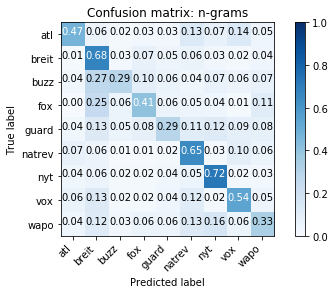

In [22]:
score_model(y_test, y_pos_pred, pub_names, 'n-grams')

In [32]:
joblib.dump(pos_string_pipeline, 'n_gram_rf.pkl') 

['n_gram_rf.pkl']

In [74]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        #print(data_dict[:2])
        #print([data_dict[i] for i in self.key][:2])#[feat] for feat in self.key] for i in data_dict][:2])
        #print(data_dict[self.key][:2])
        #return data_dict[self.key]
        #print([{i: data_dict[i]} for i in self.key])
        if self.key == 'pos_string':
            return data_dict[:,-1]
        else:
            return data_dict

class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        #print(data)
        return [{feat: row[cf] for cf, feat in enumerate(feat_list[:-1])}
                for row in data]


class PosExtractor(BaseEstimator, TransformerMixin):
    """Extract the subject & body from a usenet post in a single pass.

    Takes a sequence of strings and produces a dict of sequences.  Keys are
    `subject` and `body`.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        #print(data)
        #for i, vals in enumerate(data):
        #features = pd.DataFrame()
        #print(len(data))
        for feat in feat_list:
            features = {feat: [data[j][i] for j in range(len(data))] for i,feat in enumerate(feat_list)}
        #print(features['pos_string'][0])
        return data
        features = np.recarray(shape=(len(posts),),
                               dtype=[(feat, object) for feat in feat_list])
        for i, text in enumerate(data):
            for j, feat in enumerate(feat_list):
                features[feat][i] = data[i][j]
        #print(features['pos_string'][:2])
        return features
        
        #print(feat_list[-1], posts)
        #print({'pos_string': [i[-1] for i in posts]}['pos_string'][:2])
        #return {'pos_string': [i[-1] for i in posts]}

In [75]:
pipeline = Pipeline([
    # Extract the subject & body
    ('pos', PosExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('pos_string', Pipeline([
                ('selector', ItemSelector(key='pos_string')),
                ('vect', CountVectorizer(min_df = 1000, ngram_range=(3,4))),
                ('tfidf', TfidfTransformer()),
            ])),

            # Pipeline for pulling ad hoc features from post's body
            ('body_stats', Pipeline([
                ('selector', ItemSelector(key=[feat_list[:-1]])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'pos_string': 0.1,
            'body_stats': 1,
        },
    )),

    # Use a SVC classifier on the combined features
    ('bgt', RandomForestClassifier(n_estimators=200)),
])

# limit the list of categories to make running this example faster.
#categories = ['alt.atheism', 'talk.religion.misc']
#train = fetch_20newsgroups(random_state=1,
#                           subset='train',
#                           categories=categories,
#                           )
#test = fetch_20newsgroups(random_state=1,
#                          subset='test',
#                          categories=categories,
#                          )
print(len(X_train))
pipeline.fit(X_train, y_train)

34641


Pipeline(memory=None,
     steps=[('pos', PosExtractor()), ('union', FeatureUnion(n_jobs=1,
       transformer_list=[('pos_string', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key='pos_string')), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>,...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [76]:
y_pred = pipeline.predict(X_test)

             precision    recall  f1-score   support

          0       0.65      0.50      0.56       954
          1       0.43      0.64      0.51       929
          2       0.61      0.40      0.49       944
          3       0.52      0.52      0.52       832
          4       0.51      0.36      0.42       982
          5       0.49      0.76      0.59       997
          6       0.69      0.75      0.72       987
          7       0.59      0.57      0.58      1035
          8       0.48      0.38      0.42      1001

avg / total       0.55      0.54      0.54      8661

Normalized confusion matrix
[[0.5  0.05 0.02 0.02 0.03 0.2  0.03 0.11 0.05]
 [0.01 0.64 0.04 0.08 0.04 0.09 0.03 0.03 0.04]
 [0.04 0.2  0.4  0.1  0.08 0.02 0.04 0.05 0.05]
 [0.01 0.18 0.07 0.52 0.05 0.04 0.04 0.01 0.09]
 [0.04 0.12 0.05 0.09 0.36 0.12 0.07 0.08 0.08]
 [0.05 0.04 0.01 0.01 0.02 0.76 0.02 0.07 0.04]
 [0.03 0.04 0.01 0.02 0.04 0.04 0.75 0.02 0.04]
 [0.04 0.11 0.02 0.01 0.04 0.16 0.02 0.57 0.03]
 [

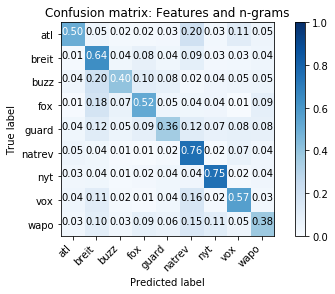

In [77]:
print(classification_report(y_test, y_pred))
score_model(y_test, y_pred, pub_names, 'Features and n-grams')

In [ ]:
feature_importances(pipeline.steps[2][1], feat_list)

In [33]:
joblib.dump(pipeline, 'combined_rf.pkl') 

['combined_rf.pkl']

In [71]:
pipeline = joblib.load('combined_rf.pkl')

In [72]:
y_pred = pipeline.predict(X_test)

Normalized confusion matrix
[[0.9  0.01 0.01 0.01 0.   0.03 0.01 0.03 0.02]
 [0.   0.93 0.01 0.01 0.01 0.02 0.01 0.01 0.01]
 [0.01 0.03 0.88 0.02 0.01 0.   0.01 0.01 0.02]
 [0.   0.04 0.01 0.91 0.01 0.01 0.   0.   0.02]
 [0.01 0.02 0.01 0.02 0.87 0.03 0.02 0.02 0.01]
 [0.01 0.01 0.   0.   0.   0.95 0.   0.02 0.01]
 [0.01 0.01 0.   0.01 0.01 0.01 0.94 0.   0.01]
 [0.01 0.02 0.   0.   0.01 0.03 0.   0.91 0.01]
 [0.01 0.02 0.01 0.01 0.02 0.02 0.01 0.01 0.89]]


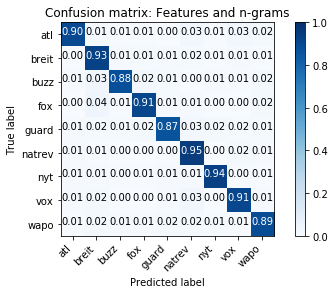

In [73]:
score_model(y_test, y_pred, pub_names, 'Features and n-grams')

In [ ]:
def compare_article(text_features):
    full_feature_df[[feat_list]].mean()
    #pub_list = [nyt, breit, wapo]
    wc_mean = [np.mean(i.word_count) for i in pub_list]
    print(wc_mean)
    #wc_mean1 = [np.mean(nyt_wc), np.mean(breit_wc), np.mean(wapo_wc)]
    #print(wc_mean, wc_mean1)
    sent_len_mean = [np.mean(i.sent_len) for i in pub_list]#, np.mean(breit_sent_len), np.mean(wapo_sent_len)]
    sent_len_std_mean = [np.mean(i.sent_len_std) for i in pub_list]#, np.mean(breit_sent_len_std), np.mean(wapo_sent_len_std)]
    unique_word_frac_mean = [np.mean(i.unique_word_frac) for i in pub_list]#, np.mean(breit_unique_word_frac), np.mean(wapo_unique_word_frac)]
    word_len_mean = [np.mean(i.word_len) for i in pub_list]#, np.mean(breit_word_len), np.mean(wapo_word_len)]
    cps_mean = [np.mean(i.cps) for i in pub_list]#, np.mean(breit_cps), np.mean(wapo_cps)]
    features = ['sentence length', 'sentence length distribution', 'unique word fraction', 'word length', 'commas per sentence']
    mean_features = [[i, j, k, l, m] for i, j, k, l, m in zip(sent_len_mean, sent_len_std_mean, unique_word_frac_mean, word_len_mean, cps_mean)]
    print(mean_features)
    pickle.dump(mean_features, open('mean_features.p', 'wb'))
    return [[float(i/j) for i,j in zip(text_features, pub_features)] for pub_features in mean_features]

In [ ]:
#pca

from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X_scaled)

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

In [ ]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'max_depth':range(3,20)}
#clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
#clf.fit(X=X_train, y=y_train)
#tree_model = clf.best_estimator_
#print (clf.best_score_, clf.best_params_) 


#clf = tree.DecisionTreeClassifier(max_depth = 5)
#clf = clf.fit(X_train, y_train)



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier


xg_clf = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=10, learning_rate=0.25,
                                 max_depth=3, random_state=0)).fit(X_train, y_train)
print(xg_clf.score(X_test, y_test))

y_pred = xg_clf.predict(X_test)

y_score = xg_clf.fit(X_train, y_train).decision_function(X_test)

In [ ]:
# Compute ROC curve and ROC area for each class

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

#GradientBoostingClassifier(n_estimators=10, learning_rate=0.25,
                                 #max_depth=3, random_state=0)
xg_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 50)).fit(X_train, y_train)
print(xg_clf.score(X_test, y_test))

y_pred = xg_clf.predict(X_test)

y_score = xg_clf.fit(X_train, y_train).decision_function(X_test)



fpr = dict()
tpr = dict()
roc_auc = dict()
print(len(pub_names))
print(len(y_test))
print(len(y_score))
for i in range(len(pub_names)):
    fpr[i], tpr[i], _ = roc_curve( (y_test == i).astype(int), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
for i in range(9):
    plt.plot(fpr[i], tpr[i], 
             lw=lw, label='{} (area = {})'.format(str(pub_names[i]), str(roc_auc[i])))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#fill in df with predicted and true labels
test_df = full_feature_df.iloc[idx_test]
test_df['true'] = y_test
test_df['pred'] = y_pred
print(y_test)

#print(len(idx_test))
#test_df = full_feature_df.lookup(*zip(*array_indices))
#print(test_df[['true','pred']])
true_pred = test_df.loc[test_df['true'] == test_df['pred']]
false_pred = test_df.loc[test_df['true'] != test_df['pred']]
pd.set_option('display.max_columns', None)
print(len(true_pred), len(false_pred))
print((true_pred.describe() - false_pred.describe()))